In [34]:
import qutip
# TODO implement this to make sure notebook runs correctly and can reproduce plots
# https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/lectures/Lecture-10-cQED-dispersive-regime.ipynb

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from qutip import (Options, about, basis, coherent, correlation, destroy,
                   expect, mesolve, ptrace, qeye, sigmax, sigmaz,
                   spectrum_correlation_fft, tensor, wigner)

%matplotlib inline

In [36]:
N = 20

wr = 2.0 * 2 * np.pi  # resonator frequency
wq = 3.0 * 2 * np.pi  # qubit frequency
chi = 0.025 * 2 * np.pi  # parameter in the dispersive hamiltonian

delta = abs(wr - wq)  # detuning
g = np.sqrt(delta * chi)  # coupling strength that is consistent with chi

In [37]:
# compare detuning and g, the first should be much larger than the second
delta / (2 * np.pi), g / (2 * np.pi)

(1.0, 0.15811388300841897)

In [38]:
# cavity operators
a = tensor(destroy(N), qeye(2))
nc = a.dag() * a
xc = a + a.dag()

# atomic operators
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
sx = tensor(qeye(N), sigmax())
nq = sm.dag() * sm
xq = sm + sm.dag()

Id = tensor(qeye(N), qeye(2))

In [39]:
# dispersive hamiltonian
H = wr * (a.dag() * a + Id / 2.0) + (wq / 2.0) * sz + chi * \
    (a.dag() * a + Id / 2) * sz

In [40]:
# psi0 = tensor(coherent(N, sqrt(6)), (basis(2,0)+basis(2,1)).unit())

In [41]:
# psi0 = tensor(thermal_dm(N, 3), ket2dm(basis(2,0)+basis(2,1))).unit()


In [42]:
psi0 = tensor(coherent(N, np.sqrt(4)), (basis(2, 0) + basis(2, 1)).unit())

In [43]:
tlist = np.linspace(0, 250, 1000)
res = mesolve(H, psi0, tlist, [], [], options=Options(nsteps=5000))

In [44]:
nc_list = expect(nc, res.states)
nq_list = expect(nq, res.states)

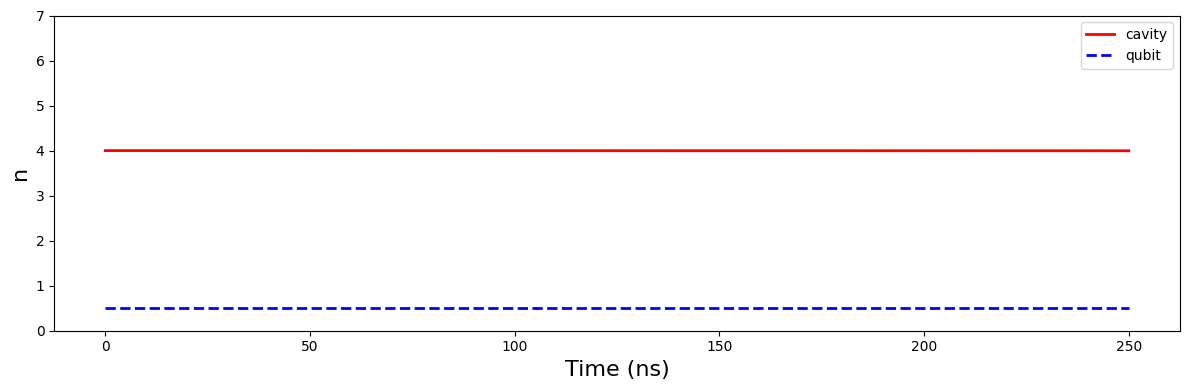

In [45]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, nc_list, "r", linewidth=2, label="cavity")
ax.plot(tlist, nq_list, "b--", linewidth=2, label="qubit")
ax.set_ylim(0, 7)
ax.set_ylabel("n", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

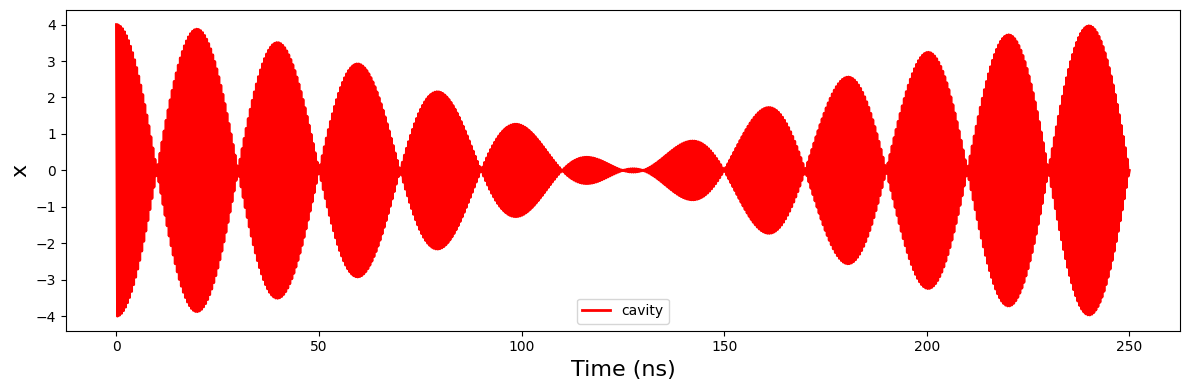

In [46]:
xc_list = expect(xc, res.states)


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, xc_list, "r", linewidth=2, label="cavity")
ax.set_ylabel("x", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()

fig.tight_layout()

In [47]:
tlist = np.linspace(0, 100, 1000)
corr_vec = correlation(H, psi0, None, tlist, [], a.dag(), a)

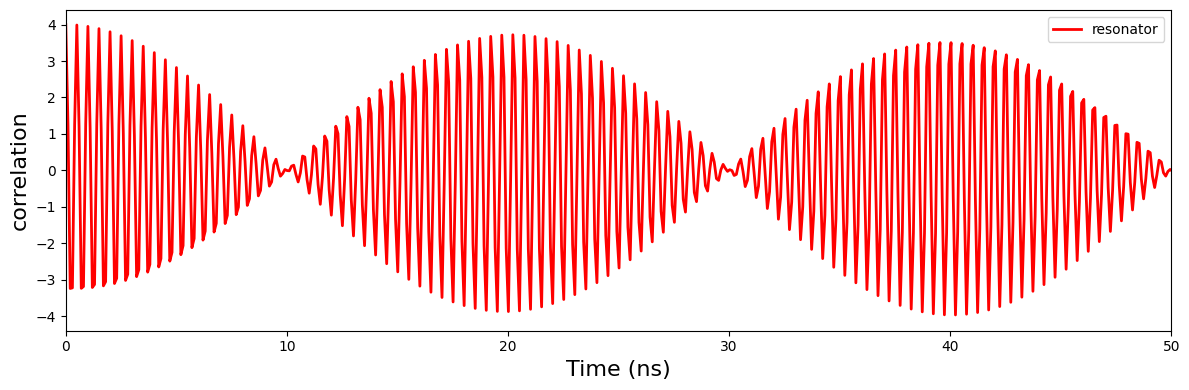

In [48]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, np.real(corr_vec), "r", linewidth=2, label="resonator")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0, 50)
fig.tight_layout()

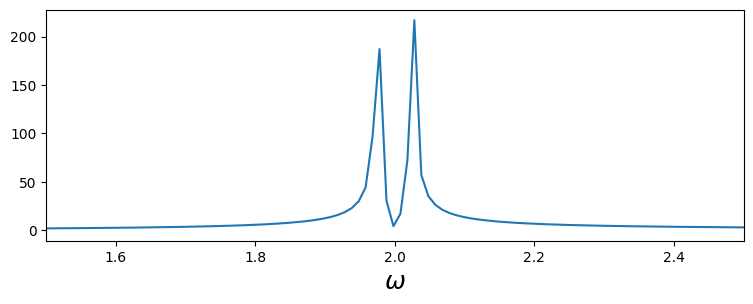

In [49]:
w, S = spectrum_correlation_fft(tlist, corr_vec)


fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(w / (2 * np.pi), abs(S))
ax.set_xlabel(r"$\omega$", fontsize=18)
ax.set_xlim(wr / (2 * np.pi) - 0.5, wr / (2 * np.pi) + 0.5);

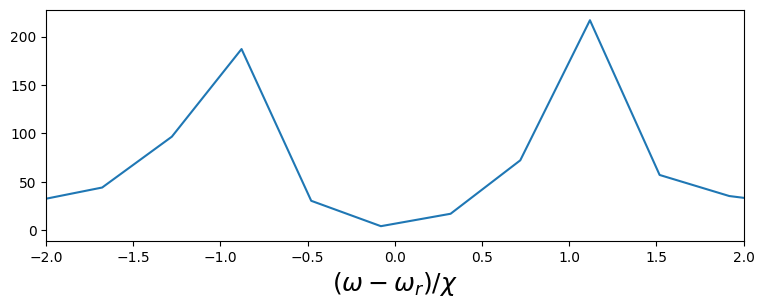

In [50]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot((w - wr) / chi, abs(S))
ax.set_xlabel(r"$(\omega-\omega_r)/\chi$", fontsize=18)
ax.set_xlim(-2, 2);

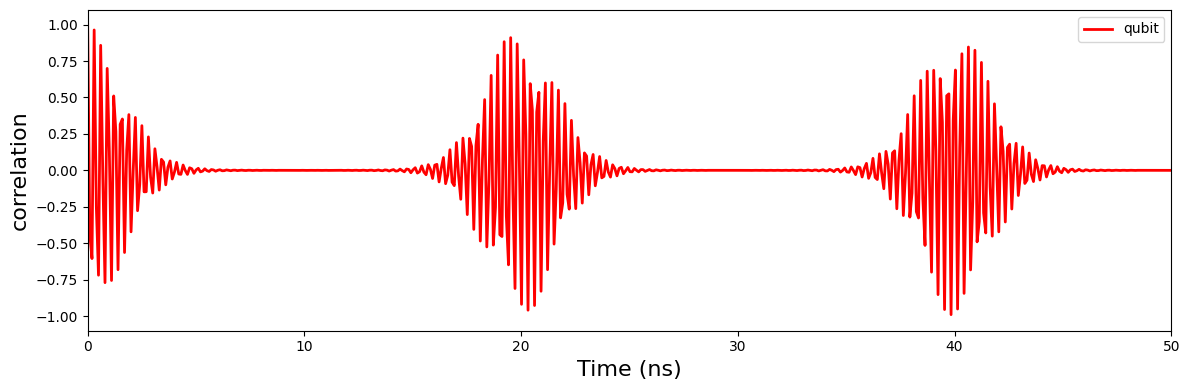

In [51]:
corr_vec = correlation(H, psi0, None, tlist, [], sx, sx)


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 4))

ax.plot(tlist, np.real(corr_vec), "r", linewidth=2, label="qubit")
ax.set_ylabel("correlation", fontsize=16)
ax.set_xlabel("Time (ns)", fontsize=16)
ax.legend()
ax.set_xlim(0, 50)
fig.tight_layout()

Text(0.5, 0, '$\\omega$')

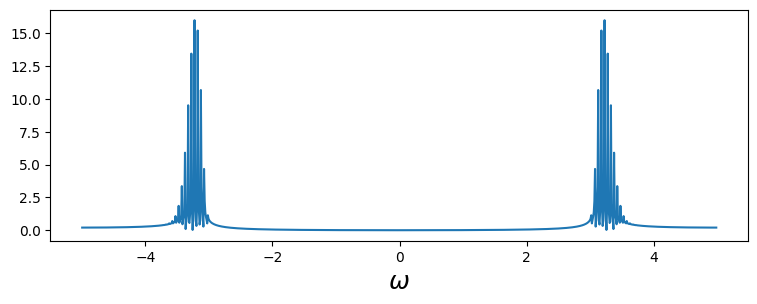

In [52]:
w, S = spectrum_correlation_fft(tlist, corr_vec)


fig, ax = plt.subplots(figsize=(9, 3))
ax.plot(w / (2 * np.pi), abs(S))
ax.set_xlabel(r"$\omega$", fontsize=18)

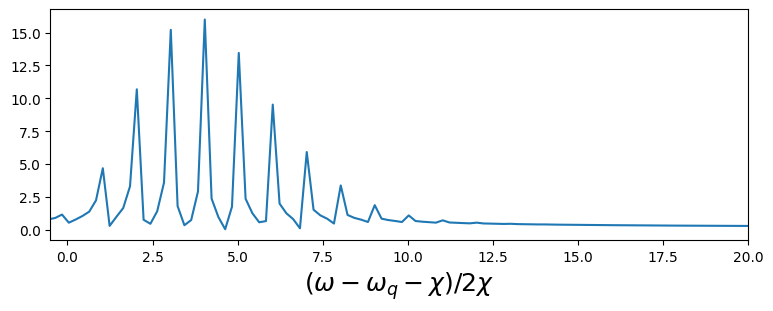

In [53]:
#to make graph clearer, shift spectrum and scale is with 2X,
fig, ax = plt.subplots(figsize=(9, 3))
ax.plot((w - wq - chi) / (2 * chi), abs(S))
ax.set_xlabel(r"$(\omega - \omega_q - \chi)/2\chi$", fontsize=18)
ax.set_xlim(-0.5, N);

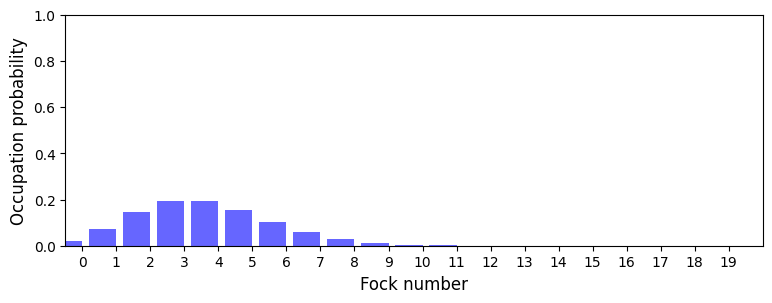

In [54]:
#compare to cavity fock state distribution
rho_cavity = ptrace(res.states[-1], 0)


fig, axes = plt.subplots(1, 1, figsize=(9, 3))

axes.bar(np.arange(0, N) - 0.4, np.real(rho_cavity.diag()), color="blue",
         alpha=0.6)
axes.set_ylim(0, 1)
axes.set_xlim(-0.5, N)
axes.set_xticks(np.arange(0, N))
axes.set_xlabel("Fock number", fontsize=12)
axes.set_ylabel("Occupation probability", fontsize=12);

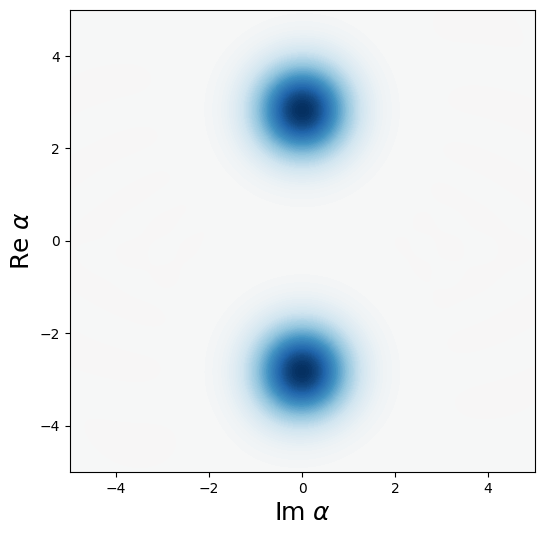

In [55]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

xvec = np.linspace(-5, 5, 200)
W = wigner(rho_cavity, xvec, xvec)
wlim = abs(W).max()

axes.contourf(
    xvec,
    xvec,
    W,
    100,
    norm=mpl.colors.Normalize(-wlim, wlim),
    cmap=plt.get_cmap("RdBu"),
)
axes.set_xlabel(r"Im $\alpha$", fontsize=18)
axes.set_ylabel(r"Re $\alpha$", fontsize=18);